**Pytorch BERT baseline**

In this version, I convert https://www.kaggle.com/akensert/bert-base-tf2-0-minimalistic into pytorch version

**Please upvote the kernel if you find it helpful**

### Install HuggingFace transformers & sacremoses dependency

As we are not allowed to use internet I've created required datasets and commands to setup Hugging Face Transformers setup in offline mode. You can find the required github codebases in the datasets.

* sacremoses dependency - https://www.kaggle.com/axel81/sacremoses
* transformers - https://www.kaggle.com/axel81/transformers

In [1]:
# !pip install ./sacremoses/sacremoses-master/
# !pip install ./transformers/transformers-master/
STRIDE = 1

### Required Imports

I've added imports that will be used in training too

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
from shutil import copyfile
DATA_DIR = '/kaggle/input/google-quest-challenge/'
BERT_PATH = './bert-base-uncased/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
sub = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')
sub.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,...,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,...,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,...,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [4]:
target_columns = sub.columns.values[1:].tolist()
target_columns

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

### Define dataset

In [5]:
train = pd.read_csv(f'{DATA_DIR}/train.csv')
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [6]:
test = pd.read_csv(f'{DATA_DIR}/test.csv')
test.head(15)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com
5,245,Exactly how are Avenger elites buffed when one...,I understand that elites with the Avenger prop...,Sterno,https://gaming.stackexchange.com/users/3062,\n Only Champion monster types will spawn wit...,ayckoster,https://gaming.stackexchange.com/users/10933,http://gaming.stackexchange.com/questions/7041...,CULTURE,gaming.stackexchange.com
6,257,Configure which plugin custom post types get r...,I am writing a plugin that creates custom post...,Rabbott,https://wordpress.stackexchange.com/users/35459,\n The issue i'm having is that custom post t...,RRikesh,https://wordpress.stackexchange.com/users/17305,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
7,267,"Why say ""it rhymes with Grape""?",There is a scene in 21 Jumpstreet where Dave F...,Kevin Howell,https://movies.stackexchange.com/users/645,Opinion: It was a funny(?) joke.\n\nAlthough a...,Andrew Martin,https://movies.stackexchange.com/users/8219,http://movies.stackexchange.com/questions/2109...,LIFE_ARTS,movies.stackexchange.com
8,284,c++ getline and stringstream,"I'm trying to read in a file, which has 5 line...",wfmn17,https://stackoverflow.com/users/1430743,If &gt;&gt; sees that there is nothing left in...,Aasmund Eldhuset,https://stackoverflow.com/users/626853,http://stackoverflow.com/questions/16374187/c-...,STACKOVERFLOW,stackoverflow.com
9,292,"Outlook doesn't download all emails, whereas i...","When I check my emails on my iPhone, I notice ...",Samantha,https://superuser.com/users/148771,It could be that your iPhone is deleting the m...,Tanner Faulkner,https://superuser.com/users/146694,http://superuser.com/questions/454556,TECHNOLOGY,superuser.com


In [7]:
len('STACKOVERFLOW')

13

In [8]:
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import time
from torch.optim import lr_scheduler

import torch
from tqdm import tqdm
#import torch.utils.data as data
from torchvision import datasets, models, transforms
from transformers import *
from sklearn.utils import shuffle
import random
from math import floor, ceil
from sklearn.model_selection import GroupKFold

MAX_LEN = 512
#MAX_Q_LEN = 250
#MAX_A_LEN = 259
SEP_TOKEN_ID = 102

class QuestDataset(torch.utils.data.Dataset):
    def __init__(self, df, train_mode=True, labeled=True):
        self.df = df
        self.train_mode = train_mode
        self.labeled = labeled
        #self.tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def __getitem__(self, index):
        row = self.df.iloc[index]
        token_ids, seg_ids, token_q_ids, token_a_ids = self.get_token_ids(row)
        
        if self.labeled:
            labels = self.get_label(row)
            return token_ids, seg_ids, token_q_ids, token_a_ids, labels
        else:
            return token_ids, seg_ids, token_q_ids, token_a_ids

    def __len__(self):
        return len(self.df)

    def select_tokens(self, tokens, max_num):
        if len(tokens) <= max_num:
            return tokens
        if self.train_mode:
            num_remove = len(tokens) - max_num
            remove_start = random.randint(0, len(tokens)-num_remove-1)
            return tokens[:remove_start] + tokens[remove_start + num_remove:]
        else:
            return tokens[:max_num//2] + tokens[-(max_num - max_num//2):]

    def trim_input(self, title, question, answer, max_sequence_length=MAX_LEN, 
                t_max_len=30, q_max_len=239, a_max_len=239):
        t = self.tokenizer.tokenize(title)
        q = self.tokenizer.tokenize(question)
        a = self.tokenizer.tokenize(answer)

        t_len = len(t)
        q_len = len(q)
        a_len = len(a)

        if (t_len+q_len+a_len+4) > max_sequence_length:

            if t_max_len > t_len:
                t_new_len = t_len
                a_max_len = a_max_len + floor((t_max_len - t_len)/2)
                q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
            else:
                t_new_len = t_max_len

            if a_max_len > a_len:
                a_new_len = a_len 
                q_new_len = q_max_len + (a_max_len - a_len)
            elif q_max_len > q_len:
                a_new_len = a_max_len + (q_max_len - q_len)
                q_new_len = q_len
            else:
                a_new_len = a_max_len
                q_new_len = q_max_len


            if t_new_len+a_new_len+q_new_len+4 != max_sequence_length:
                raise ValueError("New sequence length should be %d, but is %d" 
                                 % (max_sequence_length, (t_new_len+a_new_len+q_new_len+4)))

            t = t[:t_new_len]
            q = q[:q_new_len]
            a = a[:a_new_len]

        return t, q, a
        
    def get_token_ids(self, row):
        t_tokens, q_tokens, a_tokens = self.trim_input(row.question_title, row.question_body, row.answer)

#         tokens = ['[CLS]'] + t_tokens + q_tokens + ['[SEP]'] + a_tokens + ['[SEP]']
        tokens = ['[CLS]'] + a_tokens  + ['[SEP]']+ t_tokens + q_tokens + ['[SEP]']
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        if len(token_ids) < MAX_LEN:
            token_ids += [0] * (MAX_LEN - len(token_ids))
        ids = torch.tensor(token_ids)
        seg_ids = self.get_seg_ids(ids)
        
        tokes_q = ['[CLS]'] + t_tokens + ['[SEP]'] + q_tokens + ['[SEP]']        
        token_q_ids = self.tokenizer.convert_tokens_to_ids(tokes_q)
        if len(token_q_ids) < MAX_LEN:
            token_q_ids += [0] * (MAX_LEN - len(token_q_ids))
        ids_q = torch.tensor(token_q_ids)
            
        tokes_a = ['[CLS]'] + a_tokens + ['[SEP]', '[SEP]']  
        token_a_ids = self.tokenizer.convert_tokens_to_ids(tokes_a)
        if len(token_a_ids) < MAX_LEN:
            token_a_ids += [0] * (MAX_LEN - len(token_a_ids))
        ids_a = torch.tensor(token_a_ids)    
            
        
        return ids, seg_ids, ids_q, ids_a 
    
    def get_seg_ids(self, ids):
        seg_ids = torch.zeros_like(ids)
        seg_idx = 0
        first_sep = True
        for i, e in enumerate(ids):
            seg_ids[i] = seg_idx
            if e == SEP_TOKEN_ID:
                if first_sep:
                    first_sep = False
                else:
                    seg_idx = 1
        pad_idx = torch.nonzero(ids == 0)
        seg_ids[pad_idx] = 0

        return seg_ids

    def get_label(self, row):
        #print(row[target_columns].values)
        return torch.tensor(row[target_columns].values.astype(np.float32))

    def collate_fn(self, batch):
        token_ids = torch.stack([x[0] for x in batch])
        seg_ids = torch.stack([x[1] for x in batch])
        token_q_ids = torch.stack([x[2] for x in batch])
        token_a_ids = torch.stack([x[3] for x in batch])
        
        if self.labeled:
            labels = torch.stack([x[4] for x in batch])
            return token_ids, seg_ids, token_q_ids, token_a_ids, labels
        else:
            return token_ids, seg_ids, token_q_ids, token_a_ids, 

def get_test_loader(batch_size=4):
    df = pd.read_csv(f'{DATA_DIR}/test.csv')
    ds_test = QuestDataset(df, train_mode=False, labeled=False)
    loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=ds_test.collate_fn, drop_last=False)
    loader.num = len(df)
    
    return loader
        
def get_train_val_loaders(batch_size=4, val_batch_size=4, ifold=0):
    df = pd.read_csv(f'{DATA_DIR}/train.csv')
    df = shuffle(df, random_state=1234)
    #split_index = int(len(df) * (1-val_percent))
    gkf = GroupKFold(n_splits=5).split(X=df.question_body, groups=df.question_body)
    for fold, (train_idx, valid_idx) in enumerate(gkf):
        if fold == ifold:
            df_train = df.iloc[train_idx[::STRIDE]]
            df_val = df.iloc[valid_idx[::STRIDE]]
            break

    #print(df_val.head())
    #df_train = df[:split_index]
    #df_val = df[split_index:]

    print(df_train.shape)
    print(df_val.shape)

#     ds_train = QuestDataset(df_train.iloc[::100])
    ds_train = QuestDataset(df_train)
    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=ds_train.collate_fn, drop_last=True)
    train_loader.num = len(df_train)

#     ds_val = QuestDataset(df_val.iloc[::10], train_mode=False)
    ds_val = QuestDataset(df_val, train_mode=False)
    val_loader = torch.utils.data.DataLoader(ds_val, batch_size=val_batch_size, shuffle=False, num_workers=0, collate_fn=ds_val.collate_fn, drop_last=False)
    val_loader.num = len(df_val)
    val_loader.df = df_val

    return train_loader, val_loader

def test_train_loader():
    loader, _ = get_train_val_loaders(4, 4, 1)
    for ids, seg_ids, ids_q, ids_a, labels in loader:
        print(ids)
        print(seg_ids.numpy())
        print(labels)
        break
def test_test_loader():
    loader = get_test_loader(4)
    for ids, seg_ids, ids_q, ids_a in loader:
        print(ids)
        print(seg_ids)
        break

In [9]:
test_train_loader()

(4863, 41)
(1216, 41)
tensor([[ 101, 1045, 3685,  ...,    0,    0,    0],
        [ 101, 2017, 2097,  ...,    0,    0,    0],
        [ 101, 2013, 2158,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0]])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
tensor([[1.0000, 0.8889, 0.3333, 1.0000, 0.0000, 0.3333, 0.6667, 0.7778, 0.0000,
         0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.6667, 0.0000, 0.8889, 1.0000, 0.7778, 1.0000, 1.0000, 0.9333, 0.0000,
         0.0000, 1.0000, 0.8889],
        [0.6667, 0.3333, 0.0000, 0.0000, 1.0000, 1.0000, 0.6667, 0.6667, 1.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 0.3333, 0.6667, 0.6667, 0.6667, 1.0000, 0.8000, 0.0000,
         0.0000, 1.0000, 1.0000],
        [1.0000, 0.4444, 0.0000, 0.6667, 0.3333, 1.0000, 0.4444, 0.3333, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

In [10]:
# ifold = 0
# batch_size = 4
# df = pd.read_csv(f'{DATA_DIR}/train.csv')
# df = shuffle(df, random_state=1234)
# #split_index = int(len(df) * (1-val_percent))
# gkf = GroupKFold(n_splits=5).split(X=df.question_body, groups=df.question_body)
# for fold, (train_idx, valid_idx) in enumerate(gkf):
#     if fold == ifold:
#         df_train = df.iloc[train_idx[::STRIDE]]
#         df_val = df.iloc[valid_idx[::STRIDE]]
#         break

# #print(df_val.head())
# #df_train = df[:split_index]
# #df_val = df[split_index:]

# print(df_train.shape)
# print(df_val.shape)

# #     ds_train = QuestDataset(df_train.iloc[::100])
# ds_train = QuestDataset(df_train)
# # for _ in ds_train:
# #     print(len(_))
# #     break

# train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=ds_train.collate_fn, drop_last=True)
# train_loader.num = len(df_train)

# for _ in train_loader:
#     print(len(_))
#     break

## Build Model

In [11]:
from transformers import *
import torch
import torch.nn as nn
import torch.nn.functional as F


class QuestModel(nn.Module):
    def __init__(self, n_classes=30):
        super(QuestModel, self).__init__()
        self.model_name = 'QuestModel'
        
#         self.bert_model = BertModel.from_pretrained('bert-base-uncased') 
        self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.bert_model_q = DistilBertModel.from_pretrained('distilbert-base-uncased') 
        self.bert_model_a = DistilBertModel.from_pretrained('distilbert-base-uncased') 
        
#         ct=0
#         for child in self.bert_model.children():
#             ct += 1
#             if ct < 3:
#                 for param in child.parameters():
#                     param.requires_grad = False
        
#         self.fc = nn.Linear(768, n_classes)
#         self.fc = nn.Linear(768*3, n_classes)
    
#         self.fc1 = nn.Linear(768*3, 576)
#         self.fc2 = nn.Linear(576, 128)
#         self.fc3 = nn.Linear(128, n_classes)
        self.fc_q = nn.Linear(768*2, 21)
        self.fc_a = nn.Linear(768*2, 9)

    def forward(self, ids, ids_q, ids_a):
        attention_mask = (ids > 0)
        layers = self.bert_model(input_ids=ids, attention_mask=attention_mask)
    
        attention_mask_q = (ids_q > 0)
        layers_q = self.bert_model_q(input_ids=ids_q, attention_mask=attention_mask_q)
        
        attention_mask_a = (ids_a > 0)
        layers_a = self.bert_model_a(input_ids=ids_a, attention_mask=attention_mask_a)
        
        #print(layers[-1][0].size())
        #print(pool_out.size())
        
        
#         print(layers[-1][:, 0, :].shape)
#         #out = F.dropout(layers[-1][:, 0, :], p=0.2, training=self.training)
#         out =  F.dropout(
#             torch.cat( 
#                 (
#                     layers[-1][:, 0, :], 
#                     layers_q[-1][:, 0, :], 
#                     layers_a[-1][:, 0, :] 
#                 ), 
#                 1
#             ),
#             p=0.2, training=self.training)
        
        
        
        
#         logit = self.fc3(self.fc2(self.fc1(out)))
#         logit = self.fc(out)

#         logit_q = self.fc_q( F.dropout(layers_q[-1][:, 0, :], p=0.2, training=self.training) )
        logit_q = self.fc_q( F.dropout(
            torch.cat(
                (layers_q[-1][:, 0, :], layers[-1][:, 0, :]), 1
            )
            , p=0.2, training=self.training) )


    
        logit_a = self.fc_a( F.dropout(
            torch.cat(
                (layers_a[-1][:, 0, :], layers[-1][:, 0, :]), 1
            )
            , p=0.2, training=self.training) )
        
        logit = torch.cat(
            (logit_q, logit_a), 1
        )
        
        return logit
    


In [12]:
# training the model
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
   
    
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
#     for tcol, pcol in zip(trues, preds):
     
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

def train_model(model, train_loader, valid_loader, n_epochs=5, lr=0.001, fold=0):
    optimizer = torch.optim.Adam(model.parameters(), lr)
#     optimizer = AdamW(model.parameters(),
#                   lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
#                   eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                 )
#     patience = 2

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.25, cooldown=1, min_lr=3e-7)
#     scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
#     total_steps = len(train_loader) * n_epochs
#     scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                                 num_warmup_steps = 1, # Default value in run_glue.py
#                                                 num_training_steps = total_steps)
    
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
    best_model_val_score = 0
    best_weights_path = './models/best_weights_temp.pt'
    best_epoch = 0
    p = 0
    scores = []
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.

        for ids, seg_ids, ids_q, ids_a, targets in tqdm(train_loader, total=train_loader.num // train_loader.batch_size):
            
            
            ids, targets, ids_q, ids_a = ids.cuda(), targets.cuda(), ids_q.cuda(), ids_a.cuda()
            
            y_pred = model(ids, ids_q, ids_a)

            loss = loss_fn(y_pred.double(), targets)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
#             scheduler.step()

        model.eval()

        avg_val_loss = 0.
        preds = []
        original = []
        for i, (ids, seg_ids, ids_q, ids_a, targets) in enumerate(valid_loader):
            
            ids, targets, ids_q, ids_a = ids.cuda(), targets.cuda(), ids_q.cuda(), ids_a.cuda()
            
            y_pred = model(ids, ids_q, ids_a).detach()

            avg_val_loss += loss_fn(y_pred.double(), targets).item() / len(valid_loader)
            preds.append(y_pred.cpu().numpy())
            original.append(targets.cpu().numpy())
#         print(len(original))
        score = compute_spearmanr_ignore_nan(
            np.concatenate(original),
            np.concatenate(preds)
        )
        scores.append(score)
        val_loss.append(avg_val_loss)
        train_loss.append(avg_loss)
#         score = 0
#         for i in range(30):
#             score += np.nan_to_num(
#                 spearmanr(np.concatenate(original)[:, i], np.concatenate(preds)[:, i]).correlation / 30)
        elapsed_time = time.time() - start_time
        
        print('Epoch {}/{} \t lr={:3.1E} \t loss={:.4f} \t val_loss={:.4f} \t spearman={:.4f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, optimizer.param_groups[0]['lr'], avg_loss, avg_val_loss, score, elapsed_time))

        scheduler.step(score)
#         scheduler.step()
            
        if best_model_val_score < score:
            best_model_val_score = score
            
            torch.save(model.state_dict(), best_weights_path)
            best_epoch = epoch 
     
    
    print('Train/val losses:')
    fig = plt.figure(figsize=(12,6))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.grid()
    plt.show()
    fig.savefig(f'./figures/{start_time}_largeberttorch-fold{fold}-epoch{best_epoch}-valscore{best_model_val_score}_losses.png')
    print('Validation scores:')
    fig2= plt.figure(figsize=(12,6))
    plt.plot(scores)
    plt.legend(['val_scores'])
    plt.grid()
    plt.show()
    fig2.savefig(f'./figures/{start_time}_largeberttorch-fold{fold}-epoch{best_epoch}-valscore{best_model_val_score}_val_scores.png')

    new_best_weghts_path = f'./models/{start_time}_largeberttorch-fold{fold}-epoch{best_epoch}-valscore{best_model_val_score}.pt'
#         os.rename(best_weights_path, new_best_weghts_path)
    if not os.path.isfile(best_weights_path):
        model.save_weights(best_weights_path)

    copyfile(best_weights_path, new_best_weghts_path)

    model.load_state_dict(torch.load(new_best_weghts_path))

    pd.DataFrame({'epoch': list(range(1, 1 + len(train_loss))),
                  'train_loss': train_loss, 
                  'val_loss': val_loss, 
                  'val_score': scores})\
        .to_csv(f'./figures/{start_time}_largeberttorch-fold{fold}-epoch{best_epoch}-valscore{best_model_val_score}.csv', index=False)
        
    
    
    return model, best_model_val_score


def make_prediction(test_loader = None, model = None):
    prediction = np.zeros((len(test_loader.dataset), 30))
    model.eval()
    for i, (ids, seg_ids) in enumerate(test_loader):

        start_index = i * test_loader.batch_size
        end_index   = min(start_index + test_loader.batch_size, len(test_loader.dataset))
        
        ids, seg_ids = ids.cuda(), seg_ids.cuda()
        
        y_pred = model(ids, seg_ids).detach()
        
        y_pred = torch.sigmoid(y_pred)
        
        prediction[start_index:end_index, :] +=  y_pred.detach().cpu().numpy()
        
    return prediction

In [13]:
seed_everything()

Fold 1 started at Sat Feb  8 10:47:29 2020
(4863, 41)
(1216, 41)


100%|██████████| 1215/1215 [06:26<00:00,  3.17it/s]


Epoch 1/7 	 lr=4.0E-05 	 loss=0.3879 	 val_loss=0.3761 	 spearman=0.3707 	 time=424.29s


100%|██████████| 1215/1215 [06:26<00:00,  3.12it/s]


Epoch 2/7 	 lr=4.0E-05 	 loss=0.3613 	 val_loss=0.3738 	 spearman=0.3783 	 time=424.60s


100%|██████████| 1215/1215 [06:26<00:00,  3.15it/s]


Epoch 3/7 	 lr=4.0E-05 	 loss=0.3455 	 val_loss=0.3778 	 spearman=0.3850 	 time=424.39s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 4/7 	 lr=1.0E-05 	 loss=0.3222 	 val_loss=0.3805 	 spearman=0.3832 	 time=424.44s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 5/7 	 lr=1.0E-05 	 loss=0.3105 	 val_loss=0.3847 	 spearman=0.3771 	 time=423.93s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 6/7 	 lr=1.0E-05 	 loss=0.3007 	 val_loss=0.3927 	 spearman=0.3720 	 time=424.08s


100%|██████████| 1215/1215 [06:25<00:00,  3.14it/s]


Epoch 7/7 	 lr=2.5E-06 	 loss=0.2909 	 val_loss=0.3948 	 spearman=0.3714 	 time=423.95s
Train/val losses:


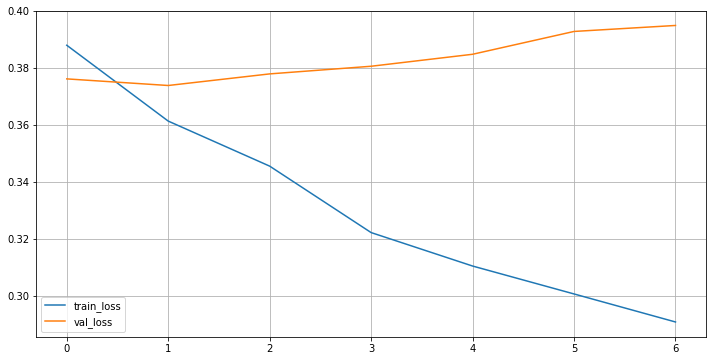

Validation scores:


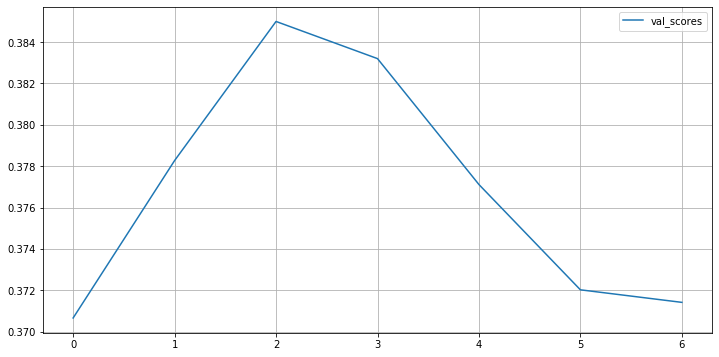


Fold 2 started at Sat Feb  8 11:37:16 2020
(4863, 41)
(1216, 41)


100%|██████████| 1215/1215 [06:25<00:00,  3.15it/s]


Epoch 1/7 	 lr=4.0E-05 	 loss=0.3887 	 val_loss=0.3743 	 spearman=0.3704 	 time=423.87s


100%|██████████| 1215/1215 [06:25<00:00,  3.13it/s]


Epoch 2/7 	 lr=4.0E-05 	 loss=0.3610 	 val_loss=0.3726 	 spearman=0.3789 	 time=424.26s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 3/7 	 lr=4.0E-05 	 loss=0.3449 	 val_loss=0.3765 	 spearman=0.3748 	 time=424.22s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 4/7 	 lr=1.0E-05 	 loss=0.3209 	 val_loss=0.3803 	 spearman=0.3772 	 time=423.86s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 5/7 	 lr=1.0E-05 	 loss=0.3096 	 val_loss=0.3854 	 spearman=0.3683 	 time=424.02s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 6/7 	 lr=1.0E-05 	 loss=0.3003 	 val_loss=0.3918 	 spearman=0.3648 	 time=423.97s


100%|██████████| 1215/1215 [06:25<00:00,  3.16it/s]


Epoch 7/7 	 lr=1.0E-05 	 loss=0.2923 	 val_loss=0.3981 	 spearman=0.3603 	 time=423.90s
Train/val losses:


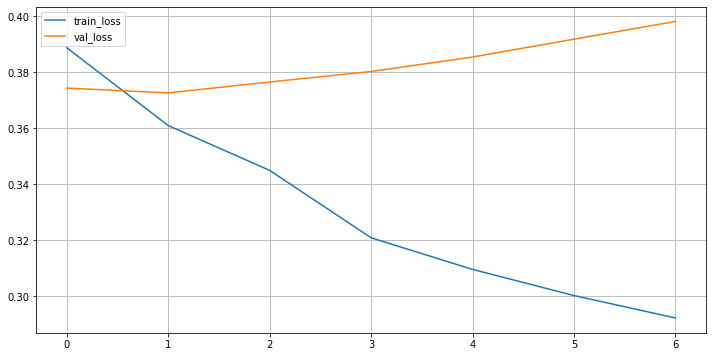

Validation scores:


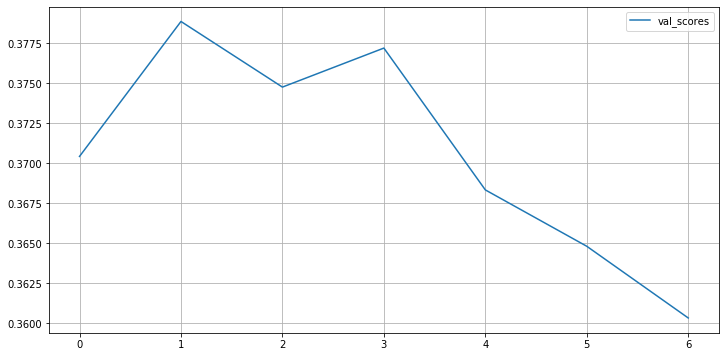


Fold 3 started at Sat Feb  8 12:26:58 2020
(4863, 41)
(1216, 41)


100%|██████████| 1215/1215 [06:25<00:00,  3.16it/s]


Epoch 1/7 	 lr=4.0E-05 	 loss=0.3896 	 val_loss=0.3738 	 spearman=0.3848 	 time=423.87s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 2/7 	 lr=4.0E-05 	 loss=0.3629 	 val_loss=0.3720 	 spearman=0.3842 	 time=423.97s


100%|██████████| 1215/1215 [06:25<00:00,  3.21it/s]


Epoch 3/7 	 lr=4.0E-05 	 loss=0.3466 	 val_loss=0.3736 	 spearman=0.3924 	 time=423.54s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 4/7 	 lr=4.0E-05 	 loss=0.3310 	 val_loss=0.3816 	 spearman=0.3875 	 time=423.64s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 5/7 	 lr=1.0E-05 	 loss=0.3070 	 val_loss=0.3832 	 spearman=0.3841 	 time=423.70s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 6/7 	 lr=1.0E-05 	 loss=0.2960 	 val_loss=0.3862 	 spearman=0.3806 	 time=427.72s


100%|██████████| 1215/1215 [06:24<00:00,  3.12it/s]


Epoch 7/7 	 lr=1.0E-05 	 loss=0.2879 	 val_loss=0.3935 	 spearman=0.3752 	 time=422.73s
Train/val losses:


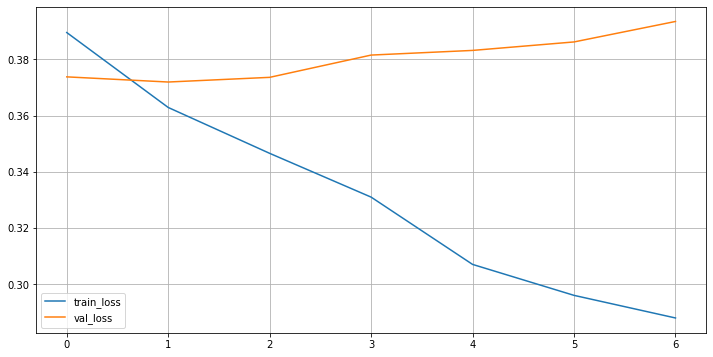

Validation scores:


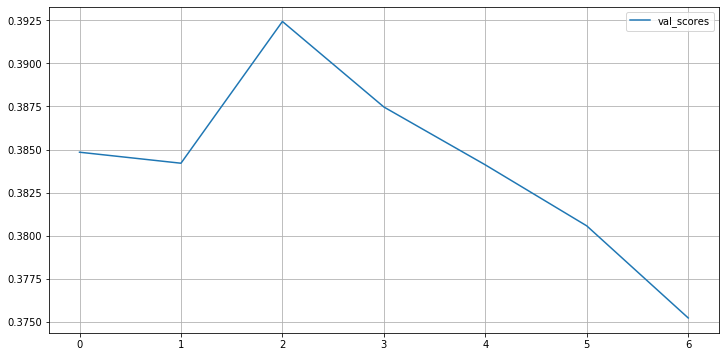


Fold 4 started at Sat Feb  8 13:16:40 2020
(4863, 41)
(1216, 41)


100%|██████████| 1215/1215 [06:25<00:00,  3.16it/s]


Epoch 1/7 	 lr=4.0E-05 	 loss=0.3893 	 val_loss=0.3769 	 spearman=0.3699 	 time=423.59s


100%|██████████| 1215/1215 [06:27<00:00,  3.18it/s]


Epoch 2/7 	 lr=4.0E-05 	 loss=0.3631 	 val_loss=0.3691 	 spearman=0.3781 	 time=425.60s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 3/7 	 lr=4.0E-05 	 loss=0.3463 	 val_loss=0.3708 	 spearman=0.3710 	 time=422.62s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 4/7 	 lr=1.0E-05 	 loss=0.3217 	 val_loss=0.3748 	 spearman=0.3749 	 time=422.91s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 5/7 	 lr=1.0E-05 	 loss=0.3097 	 val_loss=0.3812 	 spearman=0.3664 	 time=422.90s


  0%|          | 0/1215 [00:00<?, ?it/s]

Epoch 6/7 	 lr=1.0E-05 	 loss=0.2997 	 val_loss=0.3868 	 spearman=0.3616 	 time=422.98s


100%|██████████| 1215/1215 [06:24<00:00,  3.17it/s]


Epoch 7/7 	 lr=1.0E-05 	 loss=0.2916 	 val_loss=0.3935 	 spearman=0.3581 	 time=422.60s
Train/val losses:


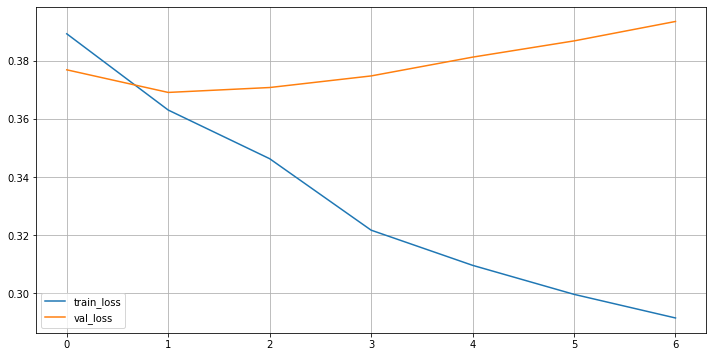

Validation scores:


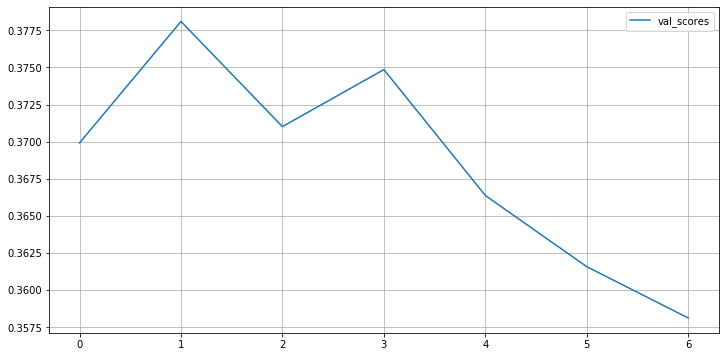


Fold 5 started at Sat Feb  8 14:06:15 2020
(4864, 41)
(1215, 41)


100%|██████████| 1216/1216 [06:25<00:00,  3.18it/s]


Epoch 1/7 	 lr=4.0E-05 	 loss=0.3894 	 val_loss=0.3780 	 spearman=0.3677 	 time=423.54s


100%|██████████| 1216/1216 [06:25<00:00,  3.08it/s]


Epoch 2/7 	 lr=4.0E-05 	 loss=0.3617 	 val_loss=0.3741 	 spearman=0.3732 	 time=423.74s


  0%|          | 0/1216 [00:00<?, ?it/s]

Epoch 3/7 	 lr=4.0E-05 	 loss=0.3458 	 val_loss=0.3749 	 spearman=0.3692 	 time=423.70s


100%|██████████| 1216/1216 [06:25<00:00,  3.17it/s]


Epoch 4/7 	 lr=1.0E-05 	 loss=0.3217 	 val_loss=0.3777 	 spearman=0.3803 	 time=423.33s


  0%|          | 0/1216 [00:00<?, ?it/s]

Epoch 5/7 	 lr=1.0E-05 	 loss=0.3101 	 val_loss=0.3833 	 spearman=0.3719 	 time=423.69s


  0%|          | 0/1216 [00:00<?, ?it/s]

Epoch 6/7 	 lr=1.0E-05 	 loss=0.3002 	 val_loss=0.3895 	 spearman=0.3669 	 time=424.19s


100%|██████████| 1216/1216 [06:26<00:00,  3.14it/s]


Epoch 7/7 	 lr=1.0E-05 	 loss=0.2924 	 val_loss=0.3955 	 spearman=0.3668 	 time=424.62s
Train/val losses:


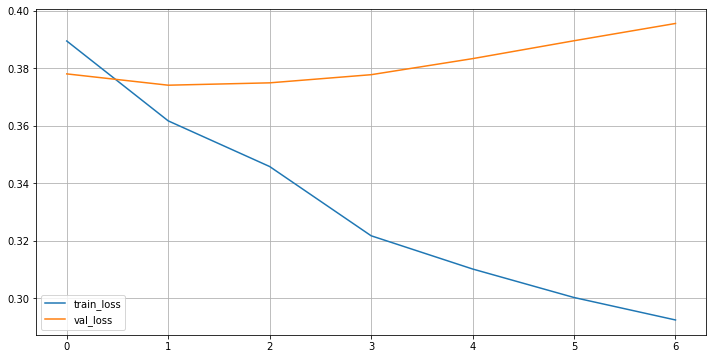

Validation scores:


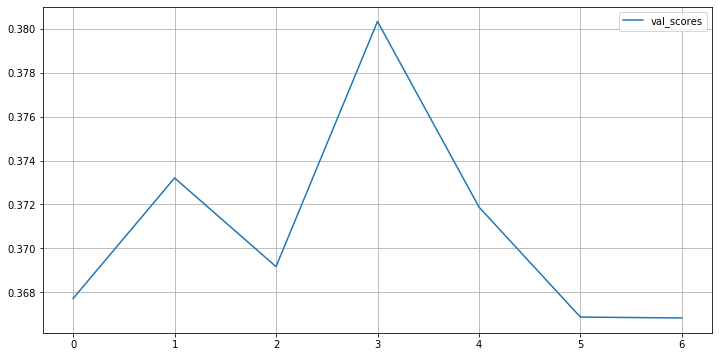


Mean validation score 0.3829508992888906


In [14]:
BATCH_SIZE = 4
test_loader = get_test_loader(batch_size=BATCH_SIZE)
# folds = KFold(n_splits=5, random_state=42)
folds = GroupKFold(n_splits=5).split(X=df_train.question_body, groups=df_train.question_body)
preds = np.zeros((len(test), 30))
best_val_scores_all =[]
for fold_n, (train_index, valid_index) in enumerate(folds):

# for fold_n, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    
    train_loader, valid_loader = get_train_val_loaders(batch_size=BATCH_SIZE, val_batch_size=BATCH_SIZE, ifold=fold_n)
        
    model = QuestModel()
    model = model.cuda()

    model, best_val_score = train_model(model, train_loader, valid_loader, n_epochs=7, lr=2e-5, fold=fold_n)
    best_val_scores_all.append(best_val_score)
#     prediction = make_prediction(test_loader, model)
    
#     preds += prediction / folds.n_splits / 2
    
    gc.collect()
    torch.cuda.empty_cache()
    print()
print(f'Mean validation score {np.mean(best_val_scores_all)}')

In [15]:
for ids, seg_ids, targets, ids_q, ids_a in train_loader:
    pass

In [16]:
def create_model(model_file):
    model = QuestModel()
    model.load_state_dict(torch.load(model_file))
    model = model.cuda()
    #model = DataParallel(model)
    return model

def create_models(files):
    models = []
    for i in range(5):
        model = create_model(f'models/'+files[i])
        model.eval()
        models.append(model)
    return models

In [17]:
def predict(models, test_loader):
    all_scores = []
    with torch.no_grad():
        for ids, seg_ids in tqdm(test_loader, total=test_loader.num // test_loader.batch_size):
            ids, seg_ids = ids.cuda(), seg_ids.cuda()
            scores = []
            for model in models:
                outputs = torch.sigmoid(model(ids, seg_ids)).cpu()
                scores.append(outputs)
            all_scores.append(torch.mean(torch.stack(scores), 0))

    all_scores = torch.cat(all_scores, 0).numpy()
    
    return all_scores


In [18]:
models = create_models(['1580853791.3290775_berthug-fold0-epoch5-valscore0.379263540166786.pt',
                       '1580857399.5879626_berthug-fold1-epoch5-valscore0.36177012785659174.pt',
                       '1580861010.799155_berthug-fold2-epoch5-valscore0.384363347108395.pt',
                       '1580864623.3608234_berthug-fold3-epoch5-valscore0.37772980866600175.pt',
                       '1580868235.6624086_berthug-fold4-epoch5-valscore0.37155434869149245.pt'])

RuntimeError: Error(s) in loading state_dict for QuestModel:
	Missing key(s) in state_dict: "bert_model.transformer.layer.0.attention.q_lin.weight", "bert_model.transformer.layer.0.attention.q_lin.bias", "bert_model.transformer.layer.0.attention.k_lin.weight", "bert_model.transformer.layer.0.attention.k_lin.bias", "bert_model.transformer.layer.0.attention.v_lin.weight", "bert_model.transformer.layer.0.attention.v_lin.bias", "bert_model.transformer.layer.0.attention.out_lin.weight", "bert_model.transformer.layer.0.attention.out_lin.bias", "bert_model.transformer.layer.0.sa_layer_norm.weight", "bert_model.transformer.layer.0.sa_layer_norm.bias", "bert_model.transformer.layer.0.ffn.lin1.weight", "bert_model.transformer.layer.0.ffn.lin1.bias", "bert_model.transformer.layer.0.ffn.lin2.weight", "bert_model.transformer.layer.0.ffn.lin2.bias", "bert_model.transformer.layer.0.output_layer_norm.weight", "bert_model.transformer.layer.0.output_layer_norm.bias", "bert_model.transformer.layer.1.attention.q_lin.weight", "bert_model.transformer.layer.1.attention.q_lin.bias", "bert_model.transformer.layer.1.attention.k_lin.weight", "bert_model.transformer.layer.1.attention.k_lin.bias", "bert_model.transformer.layer.1.attention.v_lin.weight", "bert_model.transformer.layer.1.attention.v_lin.bias", "bert_model.transformer.layer.1.attention.out_lin.weight", "bert_model.transformer.layer.1.attention.out_lin.bias", "bert_model.transformer.layer.1.sa_layer_norm.weight", "bert_model.transformer.layer.1.sa_layer_norm.bias", "bert_model.transformer.layer.1.ffn.lin1.weight", "bert_model.transformer.layer.1.ffn.lin1.bias", "bert_model.transformer.layer.1.ffn.lin2.weight", "bert_model.transformer.layer.1.ffn.lin2.bias", "bert_model.transformer.layer.1.output_layer_norm.weight", "bert_model.transformer.layer.1.output_layer_norm.bias", "bert_model.transformer.layer.2.attention.q_lin.weight", "bert_model.transformer.layer.2.attention.q_lin.bias", "bert_model.transformer.layer.2.attention.k_lin.weight", "bert_model.transformer.layer.2.attention.k_lin.bias", "bert_model.transformer.layer.2.attention.v_lin.weight", "bert_model.transformer.layer.2.attention.v_lin.bias", "bert_model.transformer.layer.2.attention.out_lin.weight", "bert_model.transformer.layer.2.attention.out_lin.bias", "bert_model.transformer.layer.2.sa_layer_norm.weight", "bert_model.transformer.layer.2.sa_layer_norm.bias", "bert_model.transformer.layer.2.ffn.lin1.weight", "bert_model.transformer.layer.2.ffn.lin1.bias", "bert_model.transformer.layer.2.ffn.lin2.weight", "bert_model.transformer.layer.2.ffn.lin2.bias", "bert_model.transformer.layer.2.output_layer_norm.weight", "bert_model.transformer.layer.2.output_layer_norm.bias", "bert_model.transformer.layer.3.attention.q_lin.weight", "bert_model.transformer.layer.3.attention.q_lin.bias", "bert_model.transformer.layer.3.attention.k_lin.weight", "bert_model.transformer.layer.3.attention.k_lin.bias", "bert_model.transformer.layer.3.attention.v_lin.weight", "bert_model.transformer.layer.3.attention.v_lin.bias", "bert_model.transformer.layer.3.attention.out_lin.weight", "bert_model.transformer.layer.3.attention.out_lin.bias", "bert_model.transformer.layer.3.sa_layer_norm.weight", "bert_model.transformer.layer.3.sa_layer_norm.bias", "bert_model.transformer.layer.3.ffn.lin1.weight", "bert_model.transformer.layer.3.ffn.lin1.bias", "bert_model.transformer.layer.3.ffn.lin2.weight", "bert_model.transformer.layer.3.ffn.lin2.bias", "bert_model.transformer.layer.3.output_layer_norm.weight", "bert_model.transformer.layer.3.output_layer_norm.bias", "bert_model.transformer.layer.4.attention.q_lin.weight", "bert_model.transformer.layer.4.attention.q_lin.bias", "bert_model.transformer.layer.4.attention.k_lin.weight", "bert_model.transformer.layer.4.attention.k_lin.bias", "bert_model.transformer.layer.4.attention.v_lin.weight", "bert_model.transformer.layer.4.attention.v_lin.bias", "bert_model.transformer.layer.4.attention.out_lin.weight", "bert_model.transformer.layer.4.attention.out_lin.bias", "bert_model.transformer.layer.4.sa_layer_norm.weight", "bert_model.transformer.layer.4.sa_layer_norm.bias", "bert_model.transformer.layer.4.ffn.lin1.weight", "bert_model.transformer.layer.4.ffn.lin1.bias", "bert_model.transformer.layer.4.ffn.lin2.weight", "bert_model.transformer.layer.4.ffn.lin2.bias", "bert_model.transformer.layer.4.output_layer_norm.weight", "bert_model.transformer.layer.4.output_layer_norm.bias", "bert_model.transformer.layer.5.attention.q_lin.weight", "bert_model.transformer.layer.5.attention.q_lin.bias", "bert_model.transformer.layer.5.attention.k_lin.weight", "bert_model.transformer.layer.5.attention.k_lin.bias", "bert_model.transformer.layer.5.attention.v_lin.weight", "bert_model.transformer.layer.5.attention.v_lin.bias", "bert_model.transformer.layer.5.attention.out_lin.weight", "bert_model.transformer.layer.5.attention.out_lin.bias", "bert_model.transformer.layer.5.sa_layer_norm.weight", "bert_model.transformer.layer.5.sa_layer_norm.bias", "bert_model.transformer.layer.5.ffn.lin1.weight", "bert_model.transformer.layer.5.ffn.lin1.bias", "bert_model.transformer.layer.5.ffn.lin2.weight", "bert_model.transformer.layer.5.ffn.lin2.bias", "bert_model.transformer.layer.5.output_layer_norm.weight", "bert_model.transformer.layer.5.output_layer_norm.bias", "bert_model_q.embeddings.word_embeddings.weight", "bert_model_q.embeddings.position_embeddings.weight", "bert_model_q.embeddings.LayerNorm.weight", "bert_model_q.embeddings.LayerNorm.bias", "bert_model_q.transformer.layer.0.attention.q_lin.weight", "bert_model_q.transformer.layer.0.attention.q_lin.bias", "bert_model_q.transformer.layer.0.attention.k_lin.weight", "bert_model_q.transformer.layer.0.attention.k_lin.bias", "bert_model_q.transformer.layer.0.attention.v_lin.weight", "bert_model_q.transformer.layer.0.attention.v_lin.bias", "bert_model_q.transformer.layer.0.attention.out_lin.weight", "bert_model_q.transformer.layer.0.attention.out_lin.bias", "bert_model_q.transformer.layer.0.sa_layer_norm.weight", "bert_model_q.transformer.layer.0.sa_layer_norm.bias", "bert_model_q.transformer.layer.0.ffn.lin1.weight", "bert_model_q.transformer.layer.0.ffn.lin1.bias", "bert_model_q.transformer.layer.0.ffn.lin2.weight", "bert_model_q.transformer.layer.0.ffn.lin2.bias", "bert_model_q.transformer.layer.0.output_layer_norm.weight", "bert_model_q.transformer.layer.0.output_layer_norm.bias", "bert_model_q.transformer.layer.1.attention.q_lin.weight", "bert_model_q.transformer.layer.1.attention.q_lin.bias", "bert_model_q.transformer.layer.1.attention.k_lin.weight", "bert_model_q.transformer.layer.1.attention.k_lin.bias", "bert_model_q.transformer.layer.1.attention.v_lin.weight", "bert_model_q.transformer.layer.1.attention.v_lin.bias", "bert_model_q.transformer.layer.1.attention.out_lin.weight", "bert_model_q.transformer.layer.1.attention.out_lin.bias", "bert_model_q.transformer.layer.1.sa_layer_norm.weight", "bert_model_q.transformer.layer.1.sa_layer_norm.bias", "bert_model_q.transformer.layer.1.ffn.lin1.weight", "bert_model_q.transformer.layer.1.ffn.lin1.bias", "bert_model_q.transformer.layer.1.ffn.lin2.weight", "bert_model_q.transformer.layer.1.ffn.lin2.bias", "bert_model_q.transformer.layer.1.output_layer_norm.weight", "bert_model_q.transformer.layer.1.output_layer_norm.bias", "bert_model_q.transformer.layer.2.attention.q_lin.weight", "bert_model_q.transformer.layer.2.attention.q_lin.bias", "bert_model_q.transformer.layer.2.attention.k_lin.weight", "bert_model_q.transformer.layer.2.attention.k_lin.bias", "bert_model_q.transformer.layer.2.attention.v_lin.weight", "bert_model_q.transformer.layer.2.attention.v_lin.bias", "bert_model_q.transformer.layer.2.attention.out_lin.weight", "bert_model_q.transformer.layer.2.attention.out_lin.bias", "bert_model_q.transformer.layer.2.sa_layer_norm.weight", "bert_model_q.transformer.layer.2.sa_layer_norm.bias", "bert_model_q.transformer.layer.2.ffn.lin1.weight", "bert_model_q.transformer.layer.2.ffn.lin1.bias", "bert_model_q.transformer.layer.2.ffn.lin2.weight", "bert_model_q.transformer.layer.2.ffn.lin2.bias", "bert_model_q.transformer.layer.2.output_layer_norm.weight", "bert_model_q.transformer.layer.2.output_layer_norm.bias", "bert_model_q.transformer.layer.3.attention.q_lin.weight", "bert_model_q.transformer.layer.3.attention.q_lin.bias", "bert_model_q.transformer.layer.3.attention.k_lin.weight", "bert_model_q.transformer.layer.3.attention.k_lin.bias", "bert_model_q.transformer.layer.3.attention.v_lin.weight", "bert_model_q.transformer.layer.3.attention.v_lin.bias", "bert_model_q.transformer.layer.3.attention.out_lin.weight", "bert_model_q.transformer.layer.3.attention.out_lin.bias", "bert_model_q.transformer.layer.3.sa_layer_norm.weight", "bert_model_q.transformer.layer.3.sa_layer_norm.bias", "bert_model_q.transformer.layer.3.ffn.lin1.weight", "bert_model_q.transformer.layer.3.ffn.lin1.bias", "bert_model_q.transformer.layer.3.ffn.lin2.weight", "bert_model_q.transformer.layer.3.ffn.lin2.bias", "bert_model_q.transformer.layer.3.output_layer_norm.weight", "bert_model_q.transformer.layer.3.output_layer_norm.bias", "bert_model_q.transformer.layer.4.attention.q_lin.weight", "bert_model_q.transformer.layer.4.attention.q_lin.bias", "bert_model_q.transformer.layer.4.attention.k_lin.weight", "bert_model_q.transformer.layer.4.attention.k_lin.bias", "bert_model_q.transformer.layer.4.attention.v_lin.weight", "bert_model_q.transformer.layer.4.attention.v_lin.bias", "bert_model_q.transformer.layer.4.attention.out_lin.weight", "bert_model_q.transformer.layer.4.attention.out_lin.bias", "bert_model_q.transformer.layer.4.sa_layer_norm.weight", "bert_model_q.transformer.layer.4.sa_layer_norm.bias", "bert_model_q.transformer.layer.4.ffn.lin1.weight", "bert_model_q.transformer.layer.4.ffn.lin1.bias", "bert_model_q.transformer.layer.4.ffn.lin2.weight", "bert_model_q.transformer.layer.4.ffn.lin2.bias", "bert_model_q.transformer.layer.4.output_layer_norm.weight", "bert_model_q.transformer.layer.4.output_layer_norm.bias", "bert_model_q.transformer.layer.5.attention.q_lin.weight", "bert_model_q.transformer.layer.5.attention.q_lin.bias", "bert_model_q.transformer.layer.5.attention.k_lin.weight", "bert_model_q.transformer.layer.5.attention.k_lin.bias", "bert_model_q.transformer.layer.5.attention.v_lin.weight", "bert_model_q.transformer.layer.5.attention.v_lin.bias", "bert_model_q.transformer.layer.5.attention.out_lin.weight", "bert_model_q.transformer.layer.5.attention.out_lin.bias", "bert_model_q.transformer.layer.5.sa_layer_norm.weight", "bert_model_q.transformer.layer.5.sa_layer_norm.bias", "bert_model_q.transformer.layer.5.ffn.lin1.weight", "bert_model_q.transformer.layer.5.ffn.lin1.bias", "bert_model_q.transformer.layer.5.ffn.lin2.weight", "bert_model_q.transformer.layer.5.ffn.lin2.bias", "bert_model_q.transformer.layer.5.output_layer_norm.weight", "bert_model_q.transformer.layer.5.output_layer_norm.bias", "bert_model_a.embeddings.word_embeddings.weight", "bert_model_a.embeddings.position_embeddings.weight", "bert_model_a.embeddings.LayerNorm.weight", "bert_model_a.embeddings.LayerNorm.bias", "bert_model_a.transformer.layer.0.attention.q_lin.weight", "bert_model_a.transformer.layer.0.attention.q_lin.bias", "bert_model_a.transformer.layer.0.attention.k_lin.weight", "bert_model_a.transformer.layer.0.attention.k_lin.bias", "bert_model_a.transformer.layer.0.attention.v_lin.weight", "bert_model_a.transformer.layer.0.attention.v_lin.bias", "bert_model_a.transformer.layer.0.attention.out_lin.weight", "bert_model_a.transformer.layer.0.attention.out_lin.bias", "bert_model_a.transformer.layer.0.sa_layer_norm.weight", "bert_model_a.transformer.layer.0.sa_layer_norm.bias", "bert_model_a.transformer.layer.0.ffn.lin1.weight", "bert_model_a.transformer.layer.0.ffn.lin1.bias", "bert_model_a.transformer.layer.0.ffn.lin2.weight", "bert_model_a.transformer.layer.0.ffn.lin2.bias", "bert_model_a.transformer.layer.0.output_layer_norm.weight", "bert_model_a.transformer.layer.0.output_layer_norm.bias", "bert_model_a.transformer.layer.1.attention.q_lin.weight", "bert_model_a.transformer.layer.1.attention.q_lin.bias", "bert_model_a.transformer.layer.1.attention.k_lin.weight", "bert_model_a.transformer.layer.1.attention.k_lin.bias", "bert_model_a.transformer.layer.1.attention.v_lin.weight", "bert_model_a.transformer.layer.1.attention.v_lin.bias", "bert_model_a.transformer.layer.1.attention.out_lin.weight", "bert_model_a.transformer.layer.1.attention.out_lin.bias", "bert_model_a.transformer.layer.1.sa_layer_norm.weight", "bert_model_a.transformer.layer.1.sa_layer_norm.bias", "bert_model_a.transformer.layer.1.ffn.lin1.weight", "bert_model_a.transformer.layer.1.ffn.lin1.bias", "bert_model_a.transformer.layer.1.ffn.lin2.weight", "bert_model_a.transformer.layer.1.ffn.lin2.bias", "bert_model_a.transformer.layer.1.output_layer_norm.weight", "bert_model_a.transformer.layer.1.output_layer_norm.bias", "bert_model_a.transformer.layer.2.attention.q_lin.weight", "bert_model_a.transformer.layer.2.attention.q_lin.bias", "bert_model_a.transformer.layer.2.attention.k_lin.weight", "bert_model_a.transformer.layer.2.attention.k_lin.bias", "bert_model_a.transformer.layer.2.attention.v_lin.weight", "bert_model_a.transformer.layer.2.attention.v_lin.bias", "bert_model_a.transformer.layer.2.attention.out_lin.weight", "bert_model_a.transformer.layer.2.attention.out_lin.bias", "bert_model_a.transformer.layer.2.sa_layer_norm.weight", "bert_model_a.transformer.layer.2.sa_layer_norm.bias", "bert_model_a.transformer.layer.2.ffn.lin1.weight", "bert_model_a.transformer.layer.2.ffn.lin1.bias", "bert_model_a.transformer.layer.2.ffn.lin2.weight", "bert_model_a.transformer.layer.2.ffn.lin2.bias", "bert_model_a.transformer.layer.2.output_layer_norm.weight", "bert_model_a.transformer.layer.2.output_layer_norm.bias", "bert_model_a.transformer.layer.3.attention.q_lin.weight", "bert_model_a.transformer.layer.3.attention.q_lin.bias", "bert_model_a.transformer.layer.3.attention.k_lin.weight", "bert_model_a.transformer.layer.3.attention.k_lin.bias", "bert_model_a.transformer.layer.3.attention.v_lin.weight", "bert_model_a.transformer.layer.3.attention.v_lin.bias", "bert_model_a.transformer.layer.3.attention.out_lin.weight", "bert_model_a.transformer.layer.3.attention.out_lin.bias", "bert_model_a.transformer.layer.3.sa_layer_norm.weight", "bert_model_a.transformer.layer.3.sa_layer_norm.bias", "bert_model_a.transformer.layer.3.ffn.lin1.weight", "bert_model_a.transformer.layer.3.ffn.lin1.bias", "bert_model_a.transformer.layer.3.ffn.lin2.weight", "bert_model_a.transformer.layer.3.ffn.lin2.bias", "bert_model_a.transformer.layer.3.output_layer_norm.weight", "bert_model_a.transformer.layer.3.output_layer_norm.bias", "bert_model_a.transformer.layer.4.attention.q_lin.weight", "bert_model_a.transformer.layer.4.attention.q_lin.bias", "bert_model_a.transformer.layer.4.attention.k_lin.weight", "bert_model_a.transformer.layer.4.attention.k_lin.bias", "bert_model_a.transformer.layer.4.attention.v_lin.weight", "bert_model_a.transformer.layer.4.attention.v_lin.bias", "bert_model_a.transformer.layer.4.attention.out_lin.weight", "bert_model_a.transformer.layer.4.attention.out_lin.bias", "bert_model_a.transformer.layer.4.sa_layer_norm.weight", "bert_model_a.transformer.layer.4.sa_layer_norm.bias", "bert_model_a.transformer.layer.4.ffn.lin1.weight", "bert_model_a.transformer.layer.4.ffn.lin1.bias", "bert_model_a.transformer.layer.4.ffn.lin2.weight", "bert_model_a.transformer.layer.4.ffn.lin2.bias", "bert_model_a.transformer.layer.4.output_layer_norm.weight", "bert_model_a.transformer.layer.4.output_layer_norm.bias", "bert_model_a.transformer.layer.5.attention.q_lin.weight", "bert_model_a.transformer.layer.5.attention.q_lin.bias", "bert_model_a.transformer.layer.5.attention.k_lin.weight", "bert_model_a.transformer.layer.5.attention.k_lin.bias", "bert_model_a.transformer.layer.5.attention.v_lin.weight", "bert_model_a.transformer.layer.5.attention.v_lin.bias", "bert_model_a.transformer.layer.5.attention.out_lin.weight", "bert_model_a.transformer.layer.5.attention.out_lin.bias", "bert_model_a.transformer.layer.5.sa_layer_norm.weight", "bert_model_a.transformer.layer.5.sa_layer_norm.bias", "bert_model_a.transformer.layer.5.ffn.lin1.weight", "bert_model_a.transformer.layer.5.ffn.lin1.bias", "bert_model_a.transformer.layer.5.ffn.lin2.weight", "bert_model_a.transformer.layer.5.ffn.lin2.bias", "bert_model_a.transformer.layer.5.output_layer_norm.weight", "bert_model_a.transformer.layer.5.output_layer_norm.bias", "fc_q.weight", "fc_q.bias", "fc_a.weight", "fc_a.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias", "bert_model.encoder.layer.0.attention.self.query.weight", "bert_model.encoder.layer.0.attention.self.query.bias", "bert_model.encoder.layer.0.attention.self.key.weight", "bert_model.encoder.layer.0.attention.self.key.bias", "bert_model.encoder.layer.0.attention.self.value.weight", "bert_model.encoder.layer.0.attention.self.value.bias", "bert_model.encoder.layer.0.attention.output.dense.weight", "bert_model.encoder.layer.0.attention.output.dense.bias", "bert_model.encoder.layer.0.attention.output.LayerNorm.weight", "bert_model.encoder.layer.0.attention.output.LayerNorm.bias", "bert_model.encoder.layer.0.intermediate.dense.weight", "bert_model.encoder.layer.0.intermediate.dense.bias", "bert_model.encoder.layer.0.output.dense.weight", "bert_model.encoder.layer.0.output.dense.bias", "bert_model.encoder.layer.0.output.LayerNorm.weight", "bert_model.encoder.layer.0.output.LayerNorm.bias", "bert_model.encoder.layer.1.attention.self.query.weight", "bert_model.encoder.layer.1.attention.self.query.bias", "bert_model.encoder.layer.1.attention.self.key.weight", "bert_model.encoder.layer.1.attention.self.key.bias", "bert_model.encoder.layer.1.attention.self.value.weight", "bert_model.encoder.layer.1.attention.self.value.bias", "bert_model.encoder.layer.1.attention.output.dense.weight", "bert_model.encoder.layer.1.attention.output.dense.bias", "bert_model.encoder.layer.1.attention.output.LayerNorm.weight", "bert_model.encoder.layer.1.attention.output.LayerNorm.bias", "bert_model.encoder.layer.1.intermediate.dense.weight", "bert_model.encoder.layer.1.intermediate.dense.bias", "bert_model.encoder.layer.1.output.dense.weight", "bert_model.encoder.layer.1.output.dense.bias", "bert_model.encoder.layer.1.output.LayerNorm.weight", "bert_model.encoder.layer.1.output.LayerNorm.bias", "bert_model.encoder.layer.2.attention.self.query.weight", "bert_model.encoder.layer.2.attention.self.query.bias", "bert_model.encoder.layer.2.attention.self.key.weight", "bert_model.encoder.layer.2.attention.self.key.bias", "bert_model.encoder.layer.2.attention.self.value.weight", "bert_model.encoder.layer.2.attention.self.value.bias", "bert_model.encoder.layer.2.attention.output.dense.weight", "bert_model.encoder.layer.2.attention.output.dense.bias", "bert_model.encoder.layer.2.attention.output.LayerNorm.weight", "bert_model.encoder.layer.2.attention.output.LayerNorm.bias", "bert_model.encoder.layer.2.intermediate.dense.weight", "bert_model.encoder.layer.2.intermediate.dense.bias", "bert_model.encoder.layer.2.output.dense.weight", "bert_model.encoder.layer.2.output.dense.bias", "bert_model.encoder.layer.2.output.LayerNorm.weight", "bert_model.encoder.layer.2.output.LayerNorm.bias", "bert_model.encoder.layer.3.attention.self.query.weight", "bert_model.encoder.layer.3.attention.self.query.bias", "bert_model.encoder.layer.3.attention.self.key.weight", "bert_model.encoder.layer.3.attention.self.key.bias", "bert_model.encoder.layer.3.attention.self.value.weight", "bert_model.encoder.layer.3.attention.self.value.bias", "bert_model.encoder.layer.3.attention.output.dense.weight", "bert_model.encoder.layer.3.attention.output.dense.bias", "bert_model.encoder.layer.3.attention.output.LayerNorm.weight", "bert_model.encoder.layer.3.attention.output.LayerNorm.bias", "bert_model.encoder.layer.3.intermediate.dense.weight", "bert_model.encoder.layer.3.intermediate.dense.bias", "bert_model.encoder.layer.3.output.dense.weight", "bert_model.encoder.layer.3.output.dense.bias", "bert_model.encoder.layer.3.output.LayerNorm.weight", "bert_model.encoder.layer.3.output.LayerNorm.bias", "bert_model.encoder.layer.4.attention.self.query.weight", "bert_model.encoder.layer.4.attention.self.query.bias", "bert_model.encoder.layer.4.attention.self.key.weight", "bert_model.encoder.layer.4.attention.self.key.bias", "bert_model.encoder.layer.4.attention.self.value.weight", "bert_model.encoder.layer.4.attention.self.value.bias", "bert_model.encoder.layer.4.attention.output.dense.weight", "bert_model.encoder.layer.4.attention.output.dense.bias", "bert_model.encoder.layer.4.attention.output.LayerNorm.weight", "bert_model.encoder.layer.4.attention.output.LayerNorm.bias", "bert_model.encoder.layer.4.intermediate.dense.weight", "bert_model.encoder.layer.4.intermediate.dense.bias", "bert_model.encoder.layer.4.output.dense.weight", "bert_model.encoder.layer.4.output.dense.bias", "bert_model.encoder.layer.4.output.LayerNorm.weight", "bert_model.encoder.layer.4.output.LayerNorm.bias", "bert_model.encoder.layer.5.attention.self.query.weight", "bert_model.encoder.layer.5.attention.self.query.bias", "bert_model.encoder.layer.5.attention.self.key.weight", "bert_model.encoder.layer.5.attention.self.key.bias", "bert_model.encoder.layer.5.attention.self.value.weight", "bert_model.encoder.layer.5.attention.self.value.bias", "bert_model.encoder.layer.5.attention.output.dense.weight", "bert_model.encoder.layer.5.attention.output.dense.bias", "bert_model.encoder.layer.5.attention.output.LayerNorm.weight", "bert_model.encoder.layer.5.attention.output.LayerNorm.bias", "bert_model.encoder.layer.5.intermediate.dense.weight", "bert_model.encoder.layer.5.intermediate.dense.bias", "bert_model.encoder.layer.5.output.dense.weight", "bert_model.encoder.layer.5.output.dense.bias", "bert_model.encoder.layer.5.output.LayerNorm.weight", "bert_model.encoder.layer.5.output.LayerNorm.bias", "bert_model.encoder.layer.6.attention.self.query.weight", "bert_model.encoder.layer.6.attention.self.query.bias", "bert_model.encoder.layer.6.attention.self.key.weight", "bert_model.encoder.layer.6.attention.self.key.bias", "bert_model.encoder.layer.6.attention.self.value.weight", "bert_model.encoder.layer.6.attention.self.value.bias", "bert_model.encoder.layer.6.attention.output.dense.weight", "bert_model.encoder.layer.6.attention.output.dense.bias", "bert_model.encoder.layer.6.attention.output.LayerNorm.weight", "bert_model.encoder.layer.6.attention.output.LayerNorm.bias", "bert_model.encoder.layer.6.intermediate.dense.weight", "bert_model.encoder.layer.6.intermediate.dense.bias", "bert_model.encoder.layer.6.output.dense.weight", "bert_model.encoder.layer.6.output.dense.bias", "bert_model.encoder.layer.6.output.LayerNorm.weight", "bert_model.encoder.layer.6.output.LayerNorm.bias", "bert_model.encoder.layer.7.attention.self.query.weight", "bert_model.encoder.layer.7.attention.self.query.bias", "bert_model.encoder.layer.7.attention.self.key.weight", "bert_model.encoder.layer.7.attention.self.key.bias", "bert_model.encoder.layer.7.attention.self.value.weight", "bert_model.encoder.layer.7.attention.self.value.bias", "bert_model.encoder.layer.7.attention.output.dense.weight", "bert_model.encoder.layer.7.attention.output.dense.bias", "bert_model.encoder.layer.7.attention.output.LayerNorm.weight", "bert_model.encoder.layer.7.attention.output.LayerNorm.bias", "bert_model.encoder.layer.7.intermediate.dense.weight", "bert_model.encoder.layer.7.intermediate.dense.bias", "bert_model.encoder.layer.7.output.dense.weight", "bert_model.encoder.layer.7.output.dense.bias", "bert_model.encoder.layer.7.output.LayerNorm.weight", "bert_model.encoder.layer.7.output.LayerNorm.bias", "bert_model.encoder.layer.8.attention.self.query.weight", "bert_model.encoder.layer.8.attention.self.query.bias", "bert_model.encoder.layer.8.attention.self.key.weight", "bert_model.encoder.layer.8.attention.self.key.bias", "bert_model.encoder.layer.8.attention.self.value.weight", "bert_model.encoder.layer.8.attention.self.value.bias", "bert_model.encoder.layer.8.attention.output.dense.weight", "bert_model.encoder.layer.8.attention.output.dense.bias", "bert_model.encoder.layer.8.attention.output.LayerNorm.weight", "bert_model.encoder.layer.8.attention.output.LayerNorm.bias", "bert_model.encoder.layer.8.intermediate.dense.weight", "bert_model.encoder.layer.8.intermediate.dense.bias", "bert_model.encoder.layer.8.output.dense.weight", "bert_model.encoder.layer.8.output.dense.bias", "bert_model.encoder.layer.8.output.LayerNorm.weight", "bert_model.encoder.layer.8.output.LayerNorm.bias", "bert_model.encoder.layer.9.attention.self.query.weight", "bert_model.encoder.layer.9.attention.self.query.bias", "bert_model.encoder.layer.9.attention.self.key.weight", "bert_model.encoder.layer.9.attention.self.key.bias", "bert_model.encoder.layer.9.attention.self.value.weight", "bert_model.encoder.layer.9.attention.self.value.bias", "bert_model.encoder.layer.9.attention.output.dense.weight", "bert_model.encoder.layer.9.attention.output.dense.bias", "bert_model.encoder.layer.9.attention.output.LayerNorm.weight", "bert_model.encoder.layer.9.attention.output.LayerNorm.bias", "bert_model.encoder.layer.9.intermediate.dense.weight", "bert_model.encoder.layer.9.intermediate.dense.bias", "bert_model.encoder.layer.9.output.dense.weight", "bert_model.encoder.layer.9.output.dense.bias", "bert_model.encoder.layer.9.output.LayerNorm.weight", "bert_model.encoder.layer.9.output.LayerNorm.bias", "bert_model.encoder.layer.10.attention.self.query.weight", "bert_model.encoder.layer.10.attention.self.query.bias", "bert_model.encoder.layer.10.attention.self.key.weight", "bert_model.encoder.layer.10.attention.self.key.bias", "bert_model.encoder.layer.10.attention.self.value.weight", "bert_model.encoder.layer.10.attention.self.value.bias", "bert_model.encoder.layer.10.attention.output.dense.weight", "bert_model.encoder.layer.10.attention.output.dense.bias", "bert_model.encoder.layer.10.attention.output.LayerNorm.weight", "bert_model.encoder.layer.10.attention.output.LayerNorm.bias", "bert_model.encoder.layer.10.intermediate.dense.weight", "bert_model.encoder.layer.10.intermediate.dense.bias", "bert_model.encoder.layer.10.output.dense.weight", "bert_model.encoder.layer.10.output.dense.bias", "bert_model.encoder.layer.10.output.LayerNorm.weight", "bert_model.encoder.layer.10.output.LayerNorm.bias", "bert_model.encoder.layer.11.attention.self.query.weight", "bert_model.encoder.layer.11.attention.self.query.bias", "bert_model.encoder.layer.11.attention.self.key.weight", "bert_model.encoder.layer.11.attention.self.key.bias", "bert_model.encoder.layer.11.attention.self.value.weight", "bert_model.encoder.layer.11.attention.self.value.bias", "bert_model.encoder.layer.11.attention.output.dense.weight", "bert_model.encoder.layer.11.attention.output.dense.bias", "bert_model.encoder.layer.11.attention.output.LayerNorm.weight", "bert_model.encoder.layer.11.attention.output.LayerNorm.bias", "bert_model.encoder.layer.11.intermediate.dense.weight", "bert_model.encoder.layer.11.intermediate.dense.bias", "bert_model.encoder.layer.11.output.dense.weight", "bert_model.encoder.layer.11.output.dense.bias", "bert_model.encoder.layer.11.output.LayerNorm.weight", "bert_model.encoder.layer.11.output.LayerNorm.bias", "bert_model.pooler.dense.weight", "bert_model.pooler.dense.bias", "bert_model.embeddings.token_type_embeddings.weight". 

In [ ]:
preds = predict(models, test_loader)

In [ ]:
preds[:1]

### Generate Submission

In [ ]:
sub[target_columns] = preds

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()